In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
print(tf.__version__) # 2.4.1

import numpy as np
import os

2.6.0


In [6]:
BATCH_SIZE = 128
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
NUM_CLASSES = 10
CHANNELS = 3

In [7]:
from keras.datasets import cifar10

def generate_datasets():
  (X_train, y_train), (X_test, y_test) = cifar10.load_data() # cifar 10 데이터셋 로드
  X_test, y_test = resize_and_rescale(X_test, y_test) 
  X_train, y_train = augment(X_train, y_train) # data augmentation
  return X_train, y_train, X_test, y_test

def resize_and_rescale(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, [IMAGE_WIDTH, IMAGE_HEIGHT])
	# training image의 intensity mean 값이 있다면 load, 없으면 구한다.
  if os.path.exists('pixel_mean_value.npy'): 
    mean_image = np.load('pixel_mean_value.npy')
  else:
    mean_image = np.mean(image, axis=0)
  image -= mean_image # per-pixel mean subtraction
  image = (image / 128.0) # normalization to [-1,1]
  return image, label

def augment(image,label):
  image, label = resize_and_rescale(image, label)
  # Add 4 pixels of padding
  image = tf.map_fn(lambda img: tf.image.resize_with_crop_or_pad(img, IMAGE_WIDTH + 4, IMAGE_HEIGHT + 4), image)
   # Random crop back to the original size
  image = tf.map_fn(lambda img: tf.image.random_crop(img, size=[IMAGE_WIDTH, IMAGE_HEIGHT, 3]), image)
  image = tf.map_fn(lambda img: tf.image.random_flip_left_right(img), image)  
  return image, label

In [8]:
class BasicBlock(tf.keras.layers.Layer):  
  def __init__(self, filter_num, stride=1):
    super(BasicBlock, self).__init__()
    initializer = tf.keras.initializers.HeNormal()
    l2 = tf.keras.regularizers.l2(0.0001)
    self.conv1 = tf.keras.layers.Conv2D(filters=filter_num, kernel_size=(3,3), 
                  strides=stride, padding='same', kernel_regularizer=l2, 
                  kernel_initializer=initializer)
    self.bn1 = tf.keras.layers.BatchNormalization()
    self.conv2 = tf.keras.layers.Conv2D(filters=filter_num, kernel_size=(3,3),
                  strides=1, padding='same', kernel_regularizer=l2, 
                  kernel_initializer=initializer)
    self.bn2 = tf.keras.layers.BatchNormalization()
    if stride != 1:
      self.downsample = tf.keras.Sequential()
      self.downsample.add(tf.keras.layers.Conv2D(filters=filter_num, kernel_size=(1,1),
                  strides=stride, kernel_regularizer=l2,
                  kernel_initializer=initializer))
      self.downsample.add(tf.keras.layers.BatchNormalization())
    else:
      self.downsample = lambda x: x

  def call(self, inputs, **kwargs):
    residual = self.downsample(inputs)

    x = self.conv1(inputs)
    x = self.bn1(x)
    x = tf.nn.relu(x)
    x = self.conv2(x)
    x = self.bn2(x)

    output = tf.nn.relu(tf.keras.layers.add([residual, x]))

    return output

def make_basic_block_layer(filter_num, blocks, stride=1):
  res_block = tf.keras.Sequential()
  res_block.add(BasicBlock(filter_num, stride=stride))

  for _ in range(1, blocks):
    res_block.add(BasicBlock(filter_num, stride=1))

  return res_block


In [9]:
class ResNet(tf.keras.Model):  
  def __init__(self, layer_params):
    super(ResNet, self).__init__()
    initializer = tf.keras.initializers.HeNormal()
    l2 = tf.keras.regularizers.l2(0.0001)
    self.conv1 = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=1, 
                    padding='same', kernel_regularizer=l2, kernel_initializer=initializer)
    self.bn1 = tf.keras.layers.BatchNormalization()
    self.layer1 = make_basic_block_layer(filter_num=16, blocks=layer_params[0], stride=2)
    self.layer2 = make_basic_block_layer(filter_num=32, blocks=layer_params[1], stride=2)
    self.layer3 = make_basic_block_layer(filter_num=64, blocks=layer_params[2], stride=2)
    self.avgpool = tf.keras.layers.GlobalAveragePooling2D()
    self.fc = tf.keras.layers.Dense(units=NUM_CLASSES, activation=tf.keras.activations.softmax,
                    kernel_regularizer=l2, kernel_initializer=initializer)

  def call(self, inputs):
    x = self.conv1(inputs)
    x = self.bn1(x)
    x = tf.nn.relu(x)
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.avgpool(x)
    output = self.fc(x)

    return output

def get_model():
  model = ResNet(layer_params=[3, 3, 3]) # basic block으로 3쌍의 conv-bn layer를 쌓음
  model.build(input_shape=(None, IMAGE_WIDTH, IMAGE_HEIGHT, CHANNELS))
  model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.1, momentum=0.9, nesterov=False), 
                    loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  model.summary()
  return model


In [11]:
X_train, y_train, X_test, y_test = generate_datasets()

In [15]:
#X_train, y_train, X_test, y_test = generate_datasets()

print('train input shape: ', X_train.shape) # (50000, 32, 32, 3)
print('test input shape: ', X_test.shape) # (10000, 32, 32, 3)
print('train output shape: ', y_train.shape) # (50000, 1)
print('train oupput shape: ', y_train.shape) # (50000, 1)

model = get_model()

lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.001)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss')

history = model.fit(X_train, y_train, epochs=100, validation_split=0.1, 
					batch_size=BATCH_SIZE, callbacks=[lr_schedule, early_stopping])


train input shape:  (50000, 32, 32, 3)
test input shape:  (10000, 32, 32, 3)
train output shape:  (50000, 1)
train oupput shape:  (50000, 1)
Model: "res_net_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           multiple                  448       
_________________________________________________________________
batch_normalization_22 (Batc multiple                  64        
_________________________________________________________________
sequential_6 (Sequential)    (None, 16, 16, 16)        14640     
_________________________________________________________________
sequential_8 (Sequential)    (None, 8, 8, 32)          52320     
_________________________________________________________________
sequential_10 (Sequential)   (None, 4, 4, 64)          207040    
_________________________________________________________________
global_average_pooling2d_1 ( multiple           

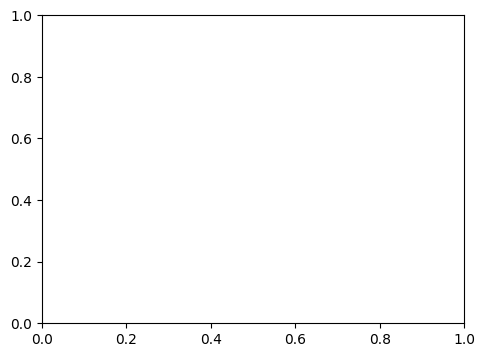

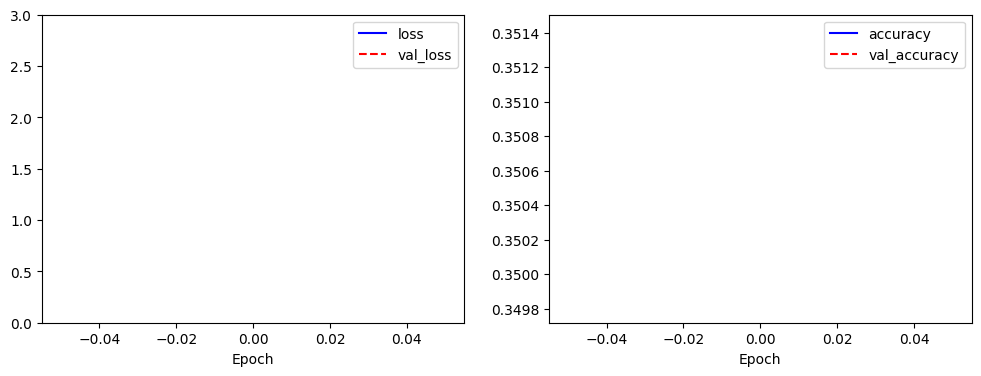

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.ylim(0, 3)
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'b-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'r--', label='val_accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.show()


In [17]:
model.evaluate(X_test, y_test, verbose=0) # [loss, accuracy]

[2.0535495281219482, 0.35519999265670776]